# Guardians of the Memory - Feature Engineering - Felix

We observed that the `smart_7_raw` shows a sawtooth behavior when it should monotonically increase. For most of the devices, the values seem to be capped at around 1e9. We unwrap the values to hopefully obtain a more useful feature.

Inspired by our baseline model, we create an additional feature (we call it `smart_999`). For this feature we calculate the exponential moving average (EMA) and compare the values to this running average. If it exceeds the EMA by more than a certain percentage, a trigger set to true.

The calculation of the features can be found in `src.features.feature_engineering`, in this notebook we perform EDA on those new features.

Content:
1. Preprocessing and calculation of feature
2. Unwrapping of `smart_7_raw`
3. `smart_999`
4. Appendix: EMA Calculation by using groupby-object





Import Libraries

In [167]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append("..")

from src.data.preprocessing import load_preprocess_data, train_test_splitter, calculate_target, drop_normalized_cols
from src.features.feature_engineering import unwrap_smart_7, ts_ema, calculate_smart_999, create_features

import pandas as pd
import numpy as np
import mlflow
# Setup MLFlow
EXPERIMENT_NAME = "guardians_of_the_memory_felix"
TRACKING_URI = open("../.mlflow_uri").read().strip()

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor, cv
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, fbeta_score
from sklearn.metrics import make_scorer, precision_recall_curve

RSEED = 42

## 1. Preprocessing and calculation of features

Load the data

In [168]:
repo_path = os.getcwd()+"/../"
df = load_preprocess_data(path=repo_path)
df_backup = df.copy()
print("Initial shape:", df.shape)

Initial shape: (462966, 42)


In [169]:
df = create_features(df, interval=30, trigger_percentage=0.05)
print("Shape after feature engineering", df.shape)

100%|██████████| 608/608 [00:29<00:00, 20.70it/s]


Shape after feature engineering (462966, 64)


Kick out rows and features

In [170]:
# Remove countdowns over 800
df = df[df.countdown <= 800]
print("Shape after removal of large countdowns:", df.shape)

# Remove smart_7_raw outlier
sn_to_drop = df[df.smart_7_raw > 5e10].serial_number.unique()
for sn in sn_to_drop:
    df.drop(df[df.serial_number == sn].index, inplace=True)
print("Shape after removal of smart_7_raw outlier:", df.shape)

Shape after removal of large countdowns: (418172, 64)
Shape after removal of smart_7_raw outlier: (416073, 64)


## 2. Unwrapping of `smart_7_raw`

Plot random single device to check

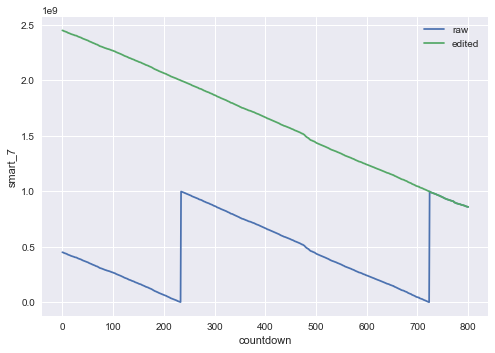

In [171]:
# Select random drive
sn = df.serial_number.unique()[np.random.randint(len(df.serial_number.unique()))]
plotdata = df[df.serial_number == sn]

sns.lineplot(x=plotdata.countdown, y=plotdata.smart_7_raw)
sns.lineplot(x=plotdata.countdown, y=plotdata.smart_7_mod)

plt.ylabel("smart_7")
plt.legend(["raw", "edited"]);

Plot median of all devices to see if the new feature is useful in prediction

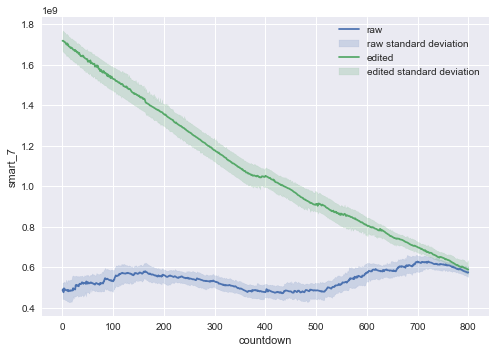

In [172]:
sns.lineplot(x=df.countdown, y=df.smart_7_raw, estimator=np.median)
sns.lineplot(x=df.countdown, y=df.smart_7_mod, estimator=np.median)

plt.ylabel("smart_7")
plt.legend(["raw", "raw standard deviation", "edited", "edited standard deviation"]);

Plot the distribution of the new feature

Text(0.5, 0, 'smart_7')

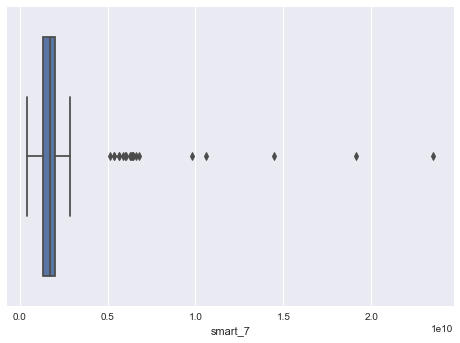

In [173]:
plotdata = df.groupby("serial_number").max().smart_7_mod
sns.boxplot(x=plotdata.values)
plt.xlabel("smart_7")

## 3. `smart_999`

Plot data for one drive

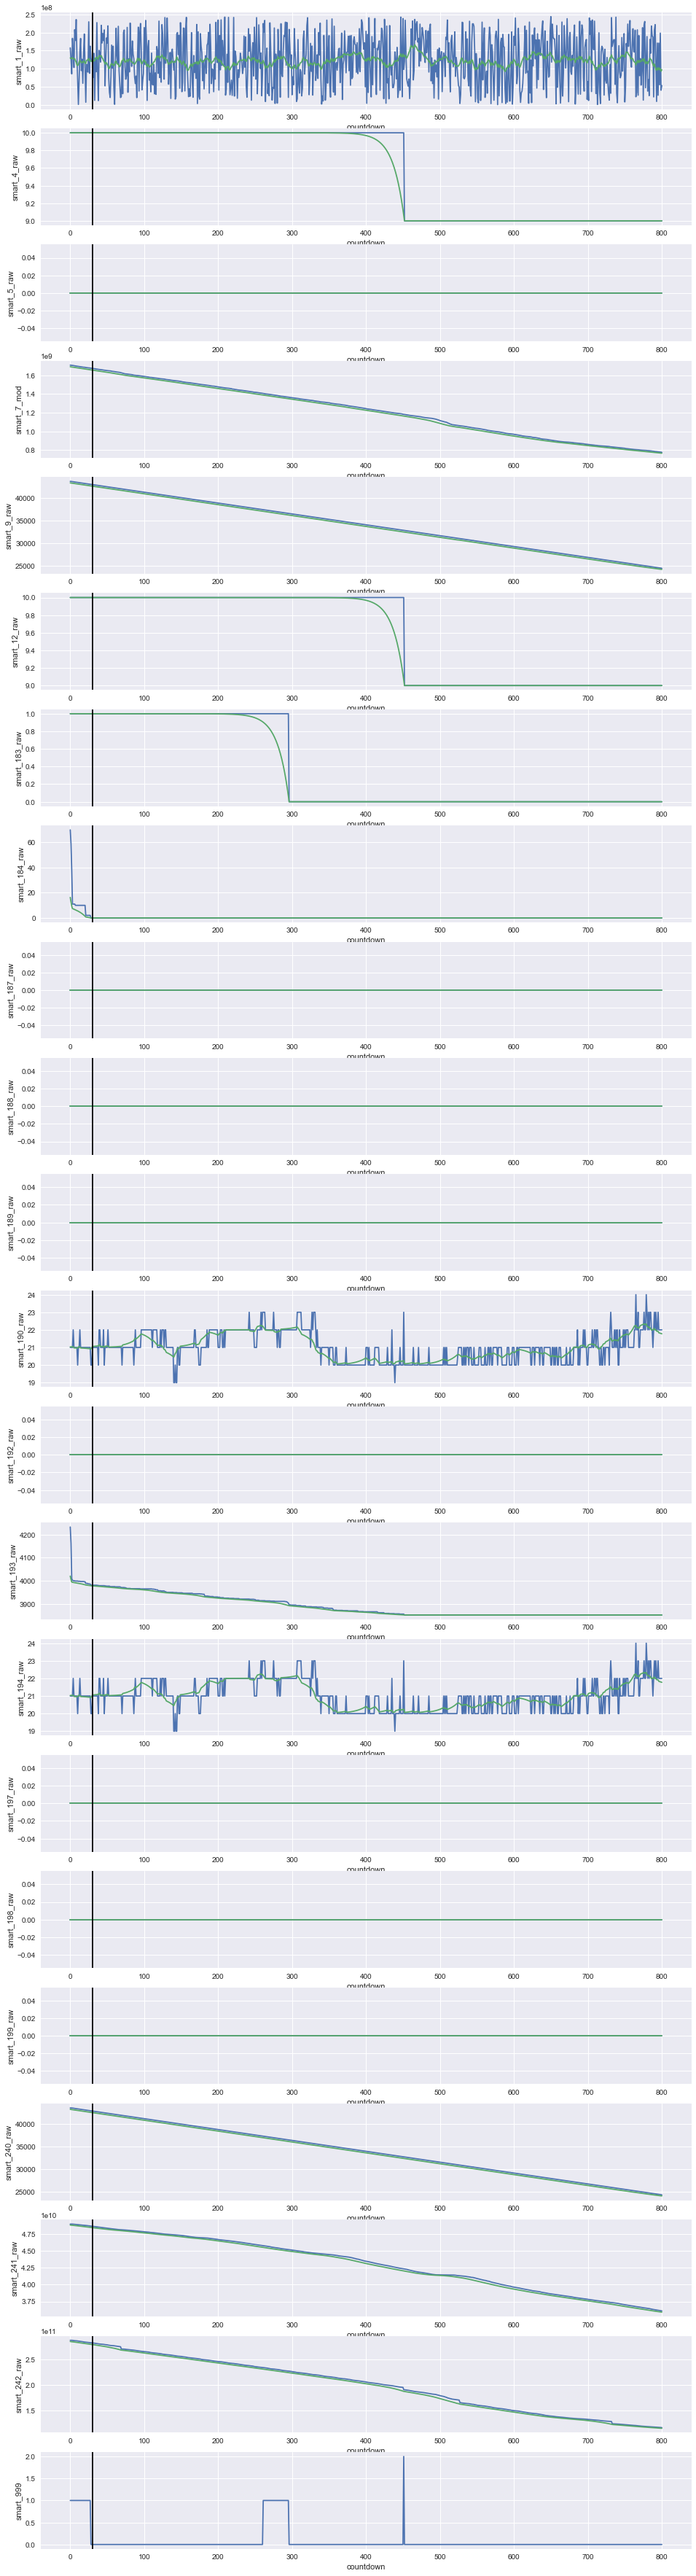

In [174]:
# Select random drive
sn = df.serial_number.unique()[np.random.randint(len(df.serial_number.unique()))]
plotdata = df[df.serial_number == sn]

time_window = 30 # Line for plotting

feats = df.columns[4:25].to_list() # Features for plotting
feats[3] = 'smart_7_mod' # Plot unwrapped smart7
plt.figure(figsize=(16,64))
for num, feat in enumerate(feats):
    plt.subplot(len(feats)+1,1,num+1)
    sns.lineplot(x=plotdata.countdown, y=plotdata[feat]) # Plot raw
    sns.lineplot(x=plotdata.countdown, y=plotdata[feat+"_ema"]) # Plot EMA
    if feat+"_inc" in df.columns:
        sns.lineplot(x=plotdata.countdown, y=plotdata[feat+"_trigger"]) # Plot inc if it exists
    plt.axvline(x=time_window, c='k')
plt.subplot(len(feats)+1,1,num+2)
sns.lineplot(x=plotdata.countdown, y=plotdata.smart_999) # Plot sum over EMA triggers
plt.axvline(x=time_window, c='k');

<AxesSubplot:xlabel='countdown', ylabel='smart_999'>

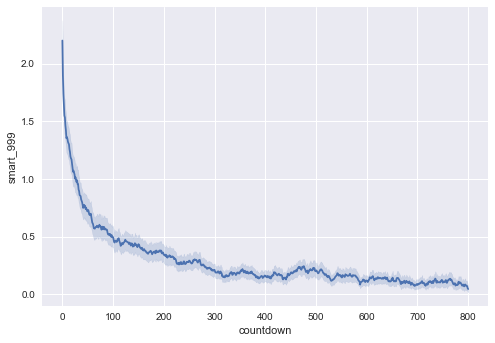

In [175]:
sns.lineplot(x=df.countdown, y=df.smart_999)

<AxesSubplot:xlabel='smart_999', ylabel='smart_9_raw'>

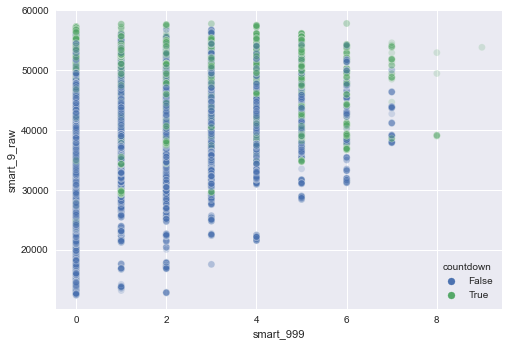

In [176]:
sns.scatterplot(x=df.smart_999, y=df.smart_9_raw, hue=calculate_target(df), alpha=0.2)

## Appendix: EMA Calculation by using groupby-object

Ok now it gets fancy.

We consider time series. Therefore, we sort the data by serial_number and date (so the different drives are separated in the dataframe with ascending dates). In order to calculate time series related features as derivatives and EMAs, we create a grouped object (grouped by serial_number) and calculate those properties for the individual drives.

In [177]:
# Features to consider in the following
feat = ["date", "serial_number", "smart_187_raw", "smart_5_raw"]
# Dataframe with only the relevant data
df2 = df.copy()[feat]
# Sort dataframe
temp = df2.copy().sort_values(["serial_number", "date"])
# Drop dat to supress warnings
temp.drop("date", inplace=True, axis=1)
# Create grouped object
grouped_data = temp.groupby("serial_number")
# Calculate features
diff_series = grouped_data.diff() # Derivative
int_series = grouped_data.ewm(span=30).mean() # EMA30
diff_sum_series = grouped_data.diff().rolling(30, min_periods=1).mean() # Rolling sum over derivative
index_series = int_series.index.get_level_values(1) # Index

In the following, we check if the grouped calculations yielded the right values. We use one serial number and compare the values

In [178]:
sn = temp.serial_number.unique()[-1] # Last serial number in dataset
test_data = temp[temp.serial_number == sn].drop("serial_number", axis=1) # Data of only this drive
diff_test = test_data.diff() # Derivative
(diff_test.iloc[1:] == diff_series.loc[diff_test.index[1:]]).all() # Compare both results

smart_187_raw    True
smart_5_raw      True
dtype: bool

In [179]:
int_test = test_data.ewm(span=30).mean() # EMA30
(int_test == int_series.loc[sn]).all() # Compare both results

smart_187_raw    True
smart_5_raw      True
dtype: bool

In [180]:
diff_sum_test = test_data.diff().rolling(30, min_periods=1).mean() # Rolling sum over derivative
(diff_sum_test.iloc[1:] == diff_sum_series.loc[diff_test.index[1:]]).all() # Compare both results

smart_187_raw    True
smart_5_raw      True
dtype: bool

Nice, all worked as expected!